# Essay Scoring Challenge

The competition dataset comprises of student-written argumentative essays. Each essay was scored on a scale of 1 to 6.  Your goal is to predict the score an essay received from its text.

The data contains 3 columns
1. **essay_id** - The unique ID of the essay
2. **full_text** - The full essay response
3. **score** - Holistic score of the essay on a 1-6 scale

Information on how essays have be graded is located here: https://storage.googleapis.com/kaggle-forum-message-attachments/2733927/20538/Rubric_%20Holistic%20Essay%20Scoring.pdf

Your task is to create an automated grader through LLMs or via traditional methods. Your scores should only be values 1-6 and not have any other information.

In [1]:
##%%capture ## this will stop printing installs
%pip install pytz
%pip install openai
%pip install langchain
%pip install langchain_community
%pip install llama-cpp-python
%pip install transformers huggingface_hub


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.6/983.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.1/366.1 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 MB 14.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend 

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
from langchain_community.chat_models import ChatOpenAI
#from langchain.agents import AgentType, initialize_agent, load_tools, Tool
#from langchain.utilities import SerpAPIWrapper ## for example for Google
## from langchain.tools import BaseTool

from transformers import pipeline
import os
from langchain import PromptTemplate, LLMChain, OpenAI

from langchain_community.llms import LlamaCpp
from langchain_core.callbacks import CallbackManager, StreamingStdOutCallbackHandler


from typing import List
import json
import tqdm
import random
from IPython.display import display, Markdown, Latex

from huggingface_hub import hf_hub_download



In [3]:
data = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vR9_S-ReAQHMCdJ0RqUJg-hg7T-Z7xs8qqxR8Vlt8bhlNu0cH0BIXYKoZsfvX5fZ1aC9KdZgHabMgiq/pub?gid=1278628737&single=true&output=csv")
test_data = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRDDvdVlzA1-VyuudRR7kgpm1OkADsngVls79ziCfVKndt4SsVVD_wDySGWPruUqxlpFPkOViZx3Z0o/pub?gid=1932597986&single=true&output=csv")

In [4]:
data.head()

,essay_id,full_text,score
0,be29f81,There is no question that the driverless car i...,4
1,be96267,"I will be telling you about a story called ""A ...",2
2,417a337,While driveless cars a cooler driving yourself...,2
3,dcf3a1e,"Dear State Senator,\n\nI do not like the Elect...",4
4,9d04b4e,"The "" Unmasking the Face on Mars"" was NOT crea...",3


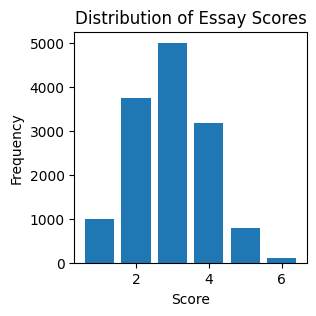

In [8]:
# @title Distribution of Essay Scores

import matplotlib.pyplot as plt

# Create the histogram
plt.figure(figsize=(3, 3))
plt.hist(data['score'], bins=range(1, 8), align='left', rwidth=0.8)
plt.xlabel('Score')
plt.ylabel('Frequency')
_ = plt.title('Distribution of Essay Scores')

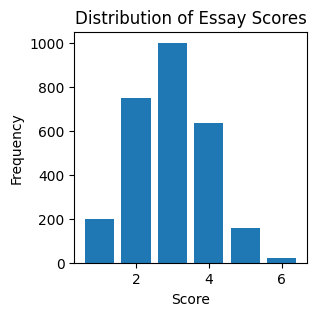

In [22]:
# @title Essay Length vs Score

import matplotlib.pyplot as plt

# Create the histogram
plt.figure(figsize=(3, 3))
plt.hist(df['score'], bins=range(1, 8), align='left', rwidth=0.8)
plt.xlabel('Score')
plt.ylabel('Frequency')
_ = plt.title('Distribution of Essay Scores')

## EDA

In [10]:
# prompt: basic exploratory data analysis

data.shape


(13845, 3)

In [19]:
# prompt: take random sample of full text and their marks from dataframe, the random sampling must represent the distribution of marks and allocate to a new dataframe called df.  total sample size to be 1200

df = data.groupby('score').apply(lambda x: x.sample(frac=0.2, random_state=42))
df = df.sample(frac=1, random_state=42)


In [20]:
df.head()

,,essay_id,full_text,score
score,,,,
3,1061,ae4bf83,Facial Action Coding is used to find the emoti...,3
2,6552,0fc7b60,"""Making Mona Lisa Smile,"" with the facial acti...",2
4,1492,f67f226,I think that using this technology to read the...,4
5,13608,850bbf9,The use of Driverless cars is a new and upcomi...,5
2,12360,f9e4d16,For me I'm not okay by techonology called the ...,2


In [21]:
df.shape

(2768, 3)

In [ ]:
# prompt: select the first raw of the column full_text

first_full_text = df['full_text'].iloc[0]


In [65]:
df['full_text'].iloc[0]

'Facial Action Coding is used to find the emotions of people based on how their muscles move in their face. As should by Mona Lisa she is "83 percent happy, 9 percent disgusted, 6 perfect fearful, and 2 perfect angry." Therefore the FACS has show. Mona Lisa\'s emotions just by the coding. As you can see FACS would be great to help out around the world.\n\nFacial Action Coding could help a lot in schools with helping people learn better. Dr. Huang states "A classroom computer could recognize when a student is becoming confused or bored," This shows that the classroom with FACS means a classroom where learning can become better. If a student is confused FACS can modify the lesson or help get the student unconfused. Also instead of students zoning out in class Facial Action Coding System will notice it. After FACS notices the student zoning out it can make sure the student zones back into the lesson. FACS can tell is someone is faking being happy. These are all reasons why VACS can help w

## LLMs  

Resource links:
1. https://python.langchain.com/v0.1/docs/modules/model_io/output_parsers/types/enum/
2. https://python.langchain.com/v0.1/docs/modules/model_io/output_parsers/types/structured/
3. https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3/

## OpenRouter
We will use OpenRouter as the API for our LLMs and use our Large Language Models via LangChain. You can use any LLM you like. Be mindful of cost, as a team you have $3 worth of credit.

https://openrouter.ai/models

## LLAMA3 8B

The LLAMA3 8B model is a freely available model by Meta (creators of Facebook).

Hugging Face link: https://huggingface.co/meta-llama/Meta-Llama-3-8B

How good is it?
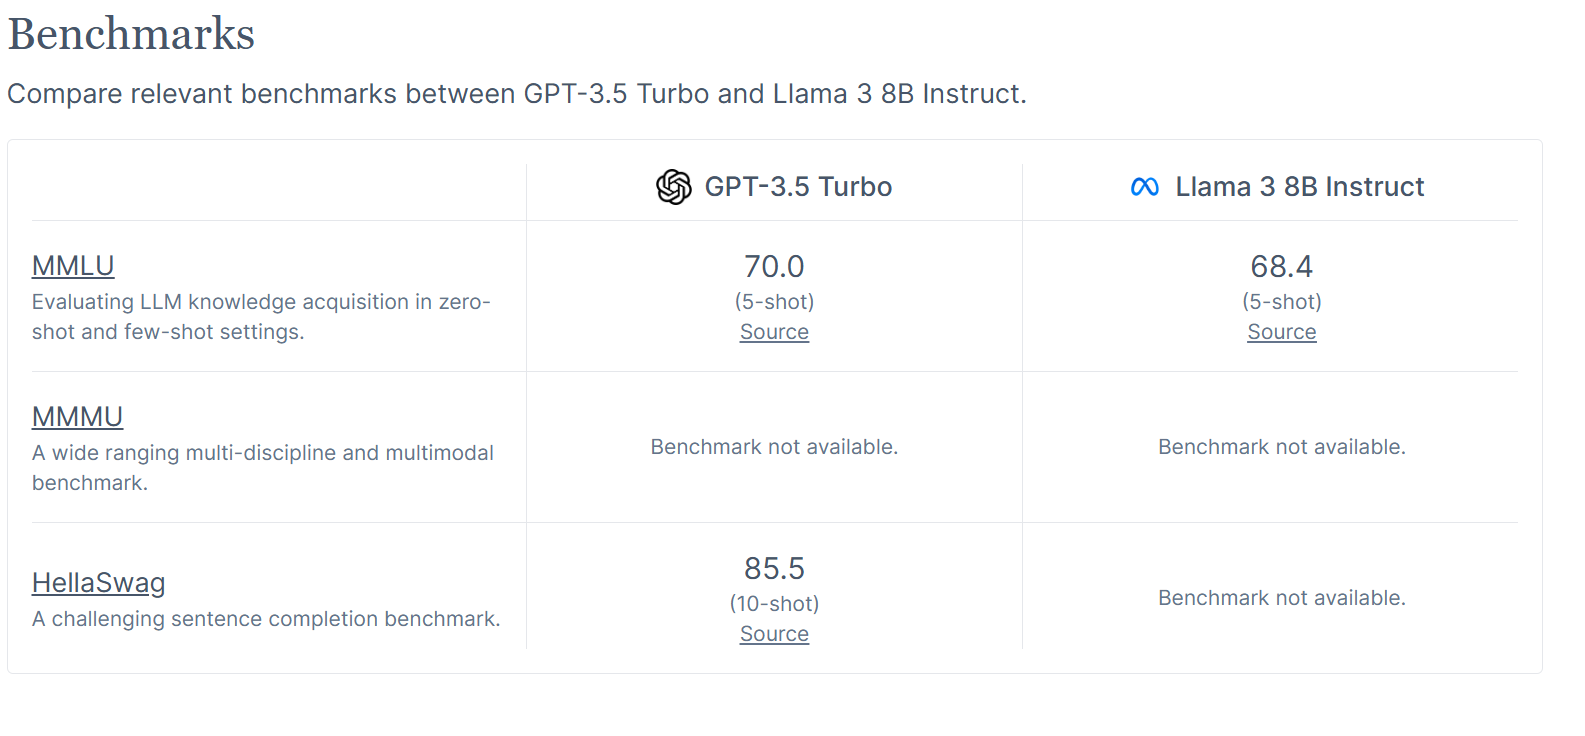




In [23]:
os.environ["OPENROUTER_API_KEY"] = "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"

In [25]:

class ChatOpenRouter(ChatOpenAI):
    openai_api_base: str
    openai_api_key: str
    model_name: str

    def __init__(self,
                 model_name: str,
                 #openai_api_key: Optional[str] = None,
                 openai_api_base: str = "https://openrouter.ai/api/v1",
                 **kwargs):
        openai_api_key = os.getenv('OPENROUTER_API_KEY')
        super().__init__(openai_api_base=openai_api_base,
                         openai_api_key=openai_api_key,
                         model_name=model_name, **kwargs)

llm = ChatOpenRouter(
    model_name="meta-llama/llama-3-8b-instruct"
)

In [26]:
display(Markdown(llm.invoke("What makes a good essay?").content))

A good essay typically possesses several key characteristics that make it effective and engaging. Here are some of the most important factors that contribute to a well-written essay:

1. **Clear thesis statement**: A strong thesis statement provides a clear direction and focus for the essay, summarizing the main argument or point.
2. **Strong organization**: A logical and coherent structure, including an introduction, body paragraphs, and a conclusion, helps to guide the reader through the essay.
3. **Effective writing style**: Clarity, concision, and persuasiveness are essential. The writer should use a formal, academic tone and avoid jargon and overly complex language.
4. **Solid evidence**: The essay should be supported by credible sources, such as academic journals, books, or reputable websites, to establish credibility and authority.
5. **Analysis and interpretation**: The writer should analyze the evidence and interpret its significance, rather than simply presenting facts.
6. **Clear and concise language**: The essay should use simple and straightforward language, avoiding ambiguity and complexity.
7. **Transitions and connections**: Seamless transitions between paragraphs and sections help to create a cohesive and logical flow.
8. **Effective use of examples and anecdotes**: Relevant and well-chosen examples and anecdotes can make the essay more engaging and memorable.
9. **Conclusion**: A strong conclusion summarizes the main points, reiterates the thesis, and leaves a lasting impression on the reader.
10. **Editing and proofreading**: Careful editing and proofreading ensure that the essay is free of errors, grammatical mistakes, and typos.
11. **Original thought and perspective**: A unique perspective or insight, backed by evidence, can make the essay stand out and demonstrate the writer's expertise.
12. **Adherence to guidelines**: The essay should follow the specified guidelines, such as word count, formatting, and citation style.

By incorporating these key elements, a good essay demonstrates the writer's ability to think critically, analyze information, and communicate their ideas effectively.

Remember, a good essay is not just about presenting information, but also about crafting a compelling argument, using evidence to support it, and engaging the reader with a clear and persuasive voice.

In [27]:
from langchain.output_parsers.enum import EnumOutputParser

In [46]:
from enum import Enum

class Score(Enum):
    ONE = '1'
    TWO = '2'
    THREE = '3'
    FOUR = '4'
    FIVE = '5'
    SIX = '6'

In [39]:
parser = EnumOutputParser(enum=Score)

In [133]:
from langchain.output_parsers import ResponseSchema, StructuredOutputParser

response_schemas = [
    ResponseSchema(name="comment", description="essay comment"),
    ResponseSchema(
        name="score",
        description="a single number - a score in 1,2,3,4,5,6 only",
        type="int",
    ),
]
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)


In [203]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate.from_template(
    """You are a helpful English teacher grading essays

{instructions}

> essay: {essay}

question: {question}


""",
    partial_variables={
        "instructions": output_parser.get_format_instructions(),
    },
)
formatted_prompt = prompt.format(essay=df['full_text'].iloc[4], question="How would you grade this essay?")


In [155]:
display(Markdown(formatted_prompt))

You are a helpful English teacher grading essays

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"comment": string  // essay comment
	"score": int  // a single number - a score in 1,2,3,4,5,6 only
}
```

> essay: For me I'm not okay by techonology called the Facial Action System because that can't tell that you can describe people's emotion, For me i think we're the only one and are family who can tell what's are emotion we can't also tell what's other's people emotions and also if you really don't know that person you can't really say or red what's their emotions. Like example even we smile in front of people that doesn't express that we're really happy etc because sometimes people smile because they don't want to see other people's worrying for them so they're just choosing to smile in front of them. Like me sometime's if im with other people even l'm sad or angry, l don't what to show what's my real emotion because l'm just choosing to smile in front of them because i don't want them to worry about my emotion or something. The only people who can read or tell what's are emotion is no other than are parents because they know us better than other people. We been on their tummy for nine months so they are the only one who can really read or tell what are emotion.

"While looking in the mirror " By looking in the mirror can't really explain or say what's are emotion are becuase mirror don't speak and it doens't tell your emotions. People use mirro just becuase they want to see what's on their face or if it's dirty or what, how they look before they go somewhere. Mirror just copying what were doing in front of the mirror like if you start talking ofcorse your twin face in the mirror also gonna start talking too,becuase mirror is just a piece of a glass that can't describe what's people's emotion. Mirror can copy what were doing but can't say what are emotion or feeling.

"Dr. Huang predict that it could be modify the lesson, like an effective human instructor. The same technology can amke computer-animated faces more expressive for video games or video surgery because of of human is nonverbal, including emotional communication. Dr. Huang said computer should understand that too becuase its really hard and different.

question: How would you grade this essay?




In [147]:

chain = llm.bind(max_tokens=100) | output_parser


In [156]:

result_dict = chain.invoke(formatted_prompt)


In [157]:
result_dict

{'comment': 'The essay could benefit from more clear and concise sentence structure, as well as improved vocabulary. Additionally, the writer could have explored the topic more deeply by providing specific examples and evidence to support their claims. That being said, the essay does demonstrate some thoughtful ideas and insights into the limitations of facial recognition technology and the importance of human emotional communication.',
 'score': 3}

In [151]:
pd.DataFrame([result_dict])

,comment,score
0,"The essay lacks coherence and clarity, with ma...",2


In [215]:
# Dictionary to store results
Final_results = []

for i in range(20):
    essay_text = df['full_text'].iloc[i]
    actual_score = df['score'].iloc[i]
    # Pass input variables as a dictionary to prompt.format()
    loop_prompt2 = prompt.format(essay=essay_text, question="How would you grade this essay? Respond in JSON format with two keys called 'score' and 'comment'.") # Modified prompt to explicitly request a valid JSON string

    # Chain operations
    chain = llm.bind(max_tokens=256) | output_parser

    # Invoke chain with formatted prompt
    results = chain.invoke(loop_prompt2)
    results.update({"actual_score":actual_score})

    # Assuming output_parser correctly parses the JSON format with 'comment' and 'score' keys
    # Store result in Final_results
    Final_results += [results]

# Display the Final_results dictionary
print("Final Results Dictionary:")
print(Final_results)

Final Results Dictionary:
[{'comment': 'The essay attempts to explain Facial Action Coding, but lacks clarity, coherence, and supporting evidence. The writer jumps between ideas without connecting them effectively, and some sentences are unclear or contain errors. However, the essay shows enthusiasm and a willingness to explore the potential applications of FACS. With improvement in organization, clarity, and writing quality, this essay could be stronger.', 'score': 3, 'actual_score': 3}, {'comment': 'The essay explores the topic of facial emotion recognition, but lacks clear structure and transitions between ideas. Some interesting points are made about the potential uses and limitations of the technology, but the writing could be more concise and focused. Overall, the essay demonstrates a good understanding of the topic, but may benefit from more attention to organization and clarity.', 'score': 4, 'actual_score': 2}, {'score': 4, 'comment': "Overall, this is a clear and concise essa

In [216]:
pd.DataFrame(Final_results)

,comment,score,actual_score
0,The essay attempts to explain Facial Action Co...,3,3
1,The essay explores the topic of facial emotion...,4,2
2,"Overall, this is a clear and concise essay tha...",4,4
3,The essay attempts to present three reasons wh...,2,5
4,The essay demonstrates some understanding of t...,2,2
5,"This essay shows good effort and enthusiasm, b...",4,2
6,"The essay lacks clarity and coherence, with ma...",2,2
7,This essay effectively uses dialogue to presen...,4,3
8,The essay is well-structured and easy to follo...,4,3
9,The essay lacks clear organization and transit...,2,2


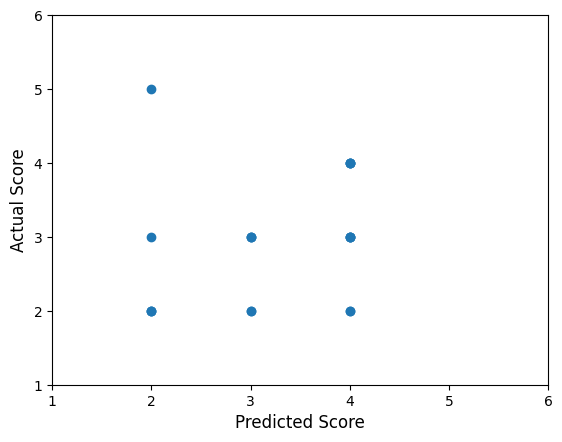

In [217]:
# prompt: scatter plot of score vs actual score, no decimal points in x and y label

import matplotlib.pyplot as plt

x = [result['score'] for result in Final_results]
y = [result['actual_score'] for result in Final_results]

plt.scatter(x, y)
plt.xlabel('Predicted Score', fontsize=12)
plt.ylabel('Actual Score', fontsize=12)
plt.xticks(np.arange(1, 7, 1))
plt.yticks(np.arange(1, 7, 1))
plt.show()


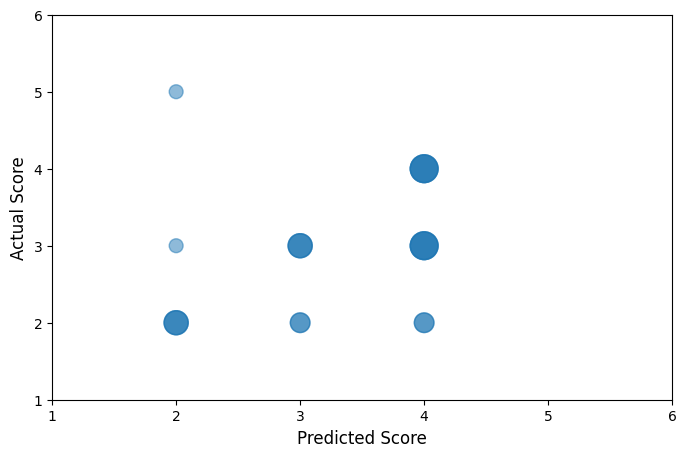

In [226]:
import matplotlib.pyplot as plt

# Extract scores and actual scores
x = [result['score'] for result in Final_results]
y = [result['actual_score'] for result in Final_results]

# Group by score and actual score and count occurrences
grouped_data = {}
for i in range(len(x)):
  key = (x[i], y[i])
  if key not in grouped_data:
    grouped_data[key] = 0
  grouped_data[key] += 1

# Calculate sizes for bubbles, ensuring same length as x and y
sizes = [grouped_data.get((x[i], y[i]), 0) * 100 for i in range(len(x))] # Use .get() with a default value to handle missing keys

# Create bubble plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, s=sizes, alpha=0.5)  # Use calculated sizes here

# Set axis labels and ticks
plt.xlabel('Predicted Score', fontsize=12)
plt.ylabel('Actual Score', fontsize=12)
plt.xticks(np.arange(1, 7, 1))
plt.yticks(np.arange(1, 7, 1))

# Remove decimal points from x and y labels
plt.gca().xaxis.set_major_formatter(lambda x, p: int(x))
plt.gca().yaxis.set_major_formatter(lambda x, p: int(x))

# Show plot
plt.show()

In [192]:
df["full_text"]

score       
3      1061     Facial Action Coding is used to find the emoti...
2      6552     "Making Mona Lisa Smile," with the facial acti...
4      1492     I think that using this technology to read the...
5      13608    The use of Driverless cars is a new and upcomi...
2      12360    For me I'm not okay by techonology called the ...
                                      ...                        
3      12215    I disagree that the use of this technology to ...
       13437    I think that driveless cars would be alot more...
       3367     The author suggest that studing murcery is a w...
       12714    This new technology can really figure out if y...
2      2607     When I participated in the Seagoing Cowboys pr...
Name: full_text, Length: 2768, dtype: object

In [197]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate.from_template(
    """You are a helpful English teacher grading essays



> essay: {essay}

question: {question}


"""
)
mistakes_prompt = prompt.format(essay=df['full_text'].iloc[5], question="are there grammer errors or punctuation mistakes?")


In [198]:
display(Markdown(mistakes_prompt))

You are a helpful English teacher grading essays



> essay: "The Seagoing Cowboys program is an adventure," stated Luke. We go all over the place, for example we have been to China and Greece. The Seagoing Cowboys program made me more aware of people's needs in other countries. When we had nothing to do we would waste time by playing games in empty holds where animals had been housed.

When I was in the Seagoing Cowboys program we helped baby cows, mules, and horses that were shipped overseas. We arrived August 14 when the Pacific war ended. Don and I headed for Greece with horses and hay and oats to feed them.

You should be apart of the program because it is fun to go on adventures and take care of the animals. Even if you don't like animals you get to have freetime and play games and visit places like China. When you unload the animals you can play tennis, boxing, reading, and whittiling. The program opened up the world for me.

When I took care of the animals they had to be fed and watered two or three times a day. Also you had to pull up bales of hay and bags of oats. Next then you had to clean the stalls out. When I worked at a farm for my aunt Katie, it prepared me for the Seagoing Cowboys program. I was greatful for the opportuniy to help the program.

You should join the program because you help people by bring the animals and you have fun at the same time. I want to go back and join the program because it was the best thing ever and it opened up the world to me by exploring and seeing other countries. When I saw the family's in need my family hosted a number of exchanged students for many years.                

question: are there grammer errors or punctuation mistakes?




In [201]:
chain2 = llm.bind(max_tokens=100)
results2 = chain2.invoke(mistakes_prompt)
results2

AIMessage(content='As an English teacher, I\'m happy to help you identify some grammar errors and punctuation mistakes in this essay.\n\nHere are some errors I\'ve found:\n\n1. **Subject-verb agreement**: In the opening sentence, "The Seagoing Cowboys program is an adventure," stated Luke." should be "The Seagoing Cowboys program is an adventure, according to Luke."\n2. **Punctuation**: There is no punctuation after "China" and "Greece" in the first paragraph. It would', response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 385, 'total_tokens': 485}, 'model_name': 'meta-llama/llama-3-8b-instruct', 'system_fingerprint': None, 'finish_reason': 'length', 'logprobs': None}, id='run-98f8358c-f6a8-4964-9d45-805f80474989-0')

In [223]:
# Construct the prompt as a chat message
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

chat_prompt = [
    SystemMessage(content="You are a helpful AI assistant."),
    HumanMessage(content="Generate SQL code to extract numbers from the 'sales_data' table.")
]

# Invoke the ChatOpenRouter to generate SQL code
response = llm(chat_prompt)

# Extract generated SQL code from response
# Access the 'content' attribute directly
sql_code = response.content.strip()
print(sql_code)

Here is an example SQL code that extracts numbers from the 'sales_data' table:
```
SELECT *
FROM sales_data
WHERE column_name REGEXP '[0-9]+';
```
This code uses the `REGEXP` function to search for one or more digits (`[0-9]+`) in the `column_name` column of the `sales_data` table. The `*` wildcard is used to select all columns.

If you want to extract specific columns that contain numbers, you can modify the code as follows:
```
SELECT column1, column2,...
FROM sales_data
WHERE column1 REGEXP '[0-9]+' OR column2 REGEXP '[0-9]+' OR...;
```
Replace `column1`, `column2`, etc. with the actual column names that you want to extract.

Alternatively, you can use the `LIKE` operator instead of `REGEXP`:
```
SELECT *
FROM sales_data
WHERE column_name LIKE '%[0-9]%';
```
This code searches for any column that contains at least one digit (`[0-9]`) anywhere in the column. The `%` wildcard is used to match any characters before and after the digit.

Note: The exact syntax may vary depending on the 

### LLAMACPP

If you want to run models on a smaller resource machine (e.g. locally, or on Google Colab free) then you can use LlamaCPP or CTranslate2.

The model we will use is not available for commercial purposes, but is a small-enough model to test and try.

Model: https://huggingface.co/stabilityai/stablelm-zephyr-3b

How good is this tiny model?

<img src="https://cdn-uploads.huggingface.co/production/uploads/6310474ca119d49bc1eb0d80/8WIZS6dAlu5kSH-382pMl.png" alt="MT-Bench Radar Chart" width="500" />


In [ ]:

# Define the repository ID and file path
repo_id = "mradermacher/stablelm-zephyr-3b-GGUF"
filename = "stablelm-zephyr-3b.Q4_K_M.gguf"

# Download the file
file_path = hf_hub_download(repo_id=repo_id, filename=filename)

# The file_path contains the local path where the file is downloaded
print(f"File downloaded to: {file_path}")

File downloaded to: /root/.cache/huggingface/hub/models--mradermacher--stablelm-zephyr-3b-GGUF/snapshots/6ab45315c6b89627e402dca9c6e3322b45e41a16/stablelm-zephyr-3b.Q4_K_M.gguf


In [ ]:
# Callbacks support token-wise streaming
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])

# Make sure the model path is correct for your system!
llmcpp = LlamaCpp(
    model_path=file_path,
    temperature=0.7,
    max_tokens=256,
    top_p=4,
    callback_manager=callback_manager,
    verbose=True,  # Verbose is required to pass to the callback manager
    #num_threads=8,  # Adjust based on your CPU
    #use_gpu=True    # Set to True if you have a compatible GPU
)

llama_model_loader: loaded meta data with 30 key-value pairs and 356 tensors from /root/.cache/huggingface/hub/models--mradermacher--stablelm-zephyr-3b-GGUF/snapshots/6ab45315c6b89627e402dca9c6e3322b45e41a16/stablelm-zephyr-3b.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = stablelm
llama_model_loader: - kv   1:                               general.name str              = stablelm-zephyr-3b
llama_model_loader: - kv   2:                    stablelm.context_length u32              = 4096
llama_model_loader: - kv   3:                  stablelm.embedding_length u32              = 2560
llama_model_loader: - kv   4:                       stablelm.block_count u32              = 32
llama_model_loader: - kv   5:               stablelm.feed_forward_length u32              = 6912
llama_model_loader: - kv   6:         

In [ ]:
template = """Question: {question}

Answer: Let's work this out in a step by step way to be sure we have the right answer."""

prompt = PromptTemplate.from_template(template)

display(Markdown('''
### Alternatively not using a PromptTemplate

You can format your prompt with as many pieces as you like, using this structure.
This is great when you need to loop through many options.

```
question = "What NFL team won the Super Bowl in the year Justin Bieber was born?"
formatted_prompt = prompt.format(question="")
llmcpp.invoke(formatted_prompt)
```
'''))


### Alternatively not using a PromptTemplate

You can format your prompt with as many pieces as you like, using this structure.
This is great when you need to loop through many options. 

```
question = "What NFL team won the Super Bowl in the year Justin Bieber was born?"
formatted_prompt = prompt.format(question="")
llmcpp.invoke(formatted_prompt)
```


In [ ]:
llm_chain = prompt | llmcpp

question = "What NFL team won the Super Bowl in the year Justin Bieber was born?"
llm_chain.invoke({"question": question})

 A Super Bowl win needs an NFL team and a specific year. is just a reference point for someone who may not know when Justin Bieber was born, so we must identify that first. 

Justin Bieber was born on March 1, 1994. Now we need to find out which NFL team won the Super Bowl in the year 1994. After searching through history and records, we can confirm that the Dallas Cowboys won Super Bowl XXXVII on January 26, 1997. Although this may seem like a mistake, it is essential to double-check since we want to ensure accuracy.

Step 1: Identify when Justin Bieber was born - March 1, 1994
Step 2: Determine which NFL team won the Super Bowl in that year - Dallas Cowboys won Super Bowl XXXVII on January 26, 1997.

Answer: The NFL team that won the Super Bowl in the year Justin Bieber was born (1994) is the Dallas Cowboys.


llama_print_timings:        load time =    6783.29 ms
llama_print_timings:      sample time =     270.76 ms /   197 runs   (    1.37 ms per token,   727.59 tokens per second)
llama_print_timings: prompt eval time =   19140.60 ms /    43 tokens (  445.13 ms per token,     2.25 tokens per second)
llama_print_timings:        eval time =   84329.72 ms /   196 runs   (  430.25 ms per token,     2.32 tokens per second)
llama_print_timings:       total time =  104923.67 ms /   239 tokens


' A Super Bowl win needs an NFL team and a specific year. is just a reference point for someone who may not know when Justin Bieber was born, so we must identify that first. \n\nJustin Bieber was born on March 1, 1994. Now we need to find out which NFL team won the Super Bowl in the year 1994. After searching through history and records, we can confirm that the Dallas Cowboys won Super Bowl XXXVII on January 26, 1997. Although this may seem like a mistake, it is essential to double-check since we want to ensure accuracy.\n\nStep 1: Identify when Justin Bieber was born - March 1, 1994\nStep 2: Determine which NFL team won the Super Bowl in that year - Dallas Cowboys won Super Bowl XXXVII on January 26, 1997.\n\nAnswer: The NFL team that won the Super Bowl in the year Justin Bieber was born (1994) is the Dallas Cowboys.'

In [ ]:
question = "What makes a good essay?"
llm_chain.invoke({"question": question})

Llama.generate: prefix-match hit


 of what makes a good essay.

Step 1: Understanding the Question
The question asks about what makes a good essay, which means we are looking for qualities or characteristics that can make an essay successful and well-written.

Step 2: Analyzing Elements of a Good Essay
A good essay should have clear organization, logical progression, cohesion, and coherence. It should also be free from errors in grammar, punctuation, spelling, and syntax. The content within the essay should be relevant, accurate, supported with credible evidence or examples, and captivating to the reader.

Step 3: Addressing Specific Aspects of a Good Essay
The introduction of an essay must grab the reader's attention and provide context for the topic being discussed. The thesis statement should be clear and concise, and it should present a central argument that the entire essay will support.

In terms of body paragraphs, each paragraph should focus on one main idea or argument related to the thesis statement. Each par


llama_print_timings:        load time =    6783.29 ms
llama_print_timings:      sample time =     308.65 ms /   256 runs   (    1.21 ms per token,   829.43 tokens per second)
llama_print_timings: prompt eval time =    5932.80 ms /    29 tokens (  204.58 ms per token,     4.89 tokens per second)
llama_print_timings:        eval time =   96527.56 ms /   255 runs   (  378.54 ms per token,     2.64 tokens per second)
llama_print_timings:       total time =  104019.39 ms /   284 tokens


" of what makes a good essay.\n\nStep 1: Understanding the Question\nThe question asks about what makes a good essay, which means we are looking for qualities or characteristics that can make an essay successful and well-written.\n\nStep 2: Analyzing Elements of a Good Essay\nA good essay should have clear organization, logical progression, cohesion, and coherence. It should also be free from errors in grammar, punctuation, spelling, and syntax. The content within the essay should be relevant, accurate, supported with credible evidence or examples, and captivating to the reader.\n\nStep 3: Addressing Specific Aspects of a Good Essay\nThe introduction of an essay must grab the reader's attention and provide context for the topic being discussed. The thesis statement should be clear and concise, and it should present a central argument that the entire essay will support.\n\nIn terms of body paragraphs, each paragraph should focus on one main idea or argument related to the thesis stateme